In [1]:
from numpy.random import seed
seed(1)
import pickle
import numpy as np
from datetime import datetime
import os

from matplotlib import pyplot as plt
from keras import regularizers, callbacks
from keras.utils.np_utils import to_categorical
from keras.layers import (Input, Dense, Activation, ZeroPadding1D, 
BatchNormalization, Flatten, Reshape, Conv1D, MaxPooling1D, Dropout,Add, LSTM,Embedding)
from keras.initializers import glorot_normal, glorot_uniform
from keras.optimizers import Adam
from keras.models import Model, load_model
#from desispec.interpolation import resample_flux

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
#plt.rcParamsDefault['axes.prop_cycle']
plt.rcParams['font.size'] = 16
plt.rcParams['axes.grid'] = True
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rc('grid',alpha=0.3,linestyle='--')

Using TensorFlow backend.
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/software/python3/3.6.5/lib/python3.6/site-packages/t

In [16]:
from keras import backend as K
def network(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    with K.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    with K.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
    with K.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    with K.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

        
    # FLATTEN -> FULLYCONNECTED
    with K.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    with K.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model2 = network((400,1))


In [17]:
import glob
from astropy.io import fits
from scipy.ndimage import median_filter
get_ipython().run_line_magic('matplotlib', 'inline')

In [18]:
files = np.sort(glob.glob((r'/home/vtiwari2/Desktop/Research/DESI sims/DESI Transient Sims/sneia*/*coadd.fits')))
flux = []
print(len(files))
for f in files:
    h = fits.open(f)
    fl = h['BRZ_FLUX'].data
    wave = h['BRZ_WAVELENGTH'].data
    zeros = np.zeros(6265)
    flux.append(fl)
flux = np.concatenate(flux)


100


In [19]:
# Removing files that have nan or just 0s
fluxes=[]
x = 0
for flu in flux:
    if (np.isnan(flu).any()) or (not np.any(flu)): #check for nan and 0(if the whole array is 0) respectively
        x += 1
    else:
        fluxes.append(flu)
print(x)
fluxes = np.asarray(fluxes)
fluxes = fluxes[fluxes.sum(axis=1)!=0]
x = len(fluxes)
subspec = np.mean(fluxes[:,:6000].reshape(-1,400,15),2)
maxflux = fluxes.max(axis=-1).reshape(-1,1)
minflux = fluxes.min(axis=-1).reshape(-1,1)
standarized = (subspec - minflux)/(maxflux-minflux)

36


In [20]:
files_host = np.sort(glob.glob((r'/home/vtiwari2/Desktop/Research/DESI sims/DESI Transient Sims/hosts*/*coadd.fits')))
flux_host = []
print(len(files_host))
for f in files_host:
    h = fits.open(f)
    wave = h['BRZ_WAVELENGTH'].data
    flux = h['BRZ_FLUX'].data
    flux_host.append(flux)

flux_host = np.concatenate(flux_host)

100


In [21]:
# Nan and 0 check
fluxes_hosts = []
x = 0
for flux in flux_host:
    if (np.isnan(flux).any()) or (not np.any(flux)): #check for nan and 0(if the whole array is 0) respectively
        x += 1
    else:
        fluxes_hosts.append(flux)
print(x)
fluxes_hosts = np.asarray(fluxes_hosts)
fluxes_hosts = fluxes_hosts[fluxes_hosts.sum(axis=1)!=0]
x = len(fluxes_hosts)
subspec_hosts = np.mean(fluxes_hosts[:,:6000].reshape(-1,400,15),2)
maxflux = fluxes_hosts.max(axis=-1).reshape(-1,1)
minflux = fluxes_hosts.min(axis=-1).reshape(-1,1)
standarized_hosts = (subspec_hosts - minflux)/(maxflux-minflux)

31


In [22]:
x_train = np.concatenate([standarized,standarized_hosts]).reshape(-1,400,1)
y_train = np.concatenate([np.zeros(standarized.shape[0]),np.ones(standarized_hosts.shape[0])])
permute = np.random.permutation(y_train.shape[0])


In [23]:
l = len(x_train)
hist = model2.fit(x_train[permute][:l],y_train[permute][:l],batch_size=64,epochs=50,
                  validation_split=0.1,shuffle=True)

Train on 17939 samples, validate on 1994 samples
Epoch 1/50
17939/17939 [==============================] - 30s 2ms/step - loss: 1.6202 - acc: 0.5400 - val_loss: 1.2085 - val_acc: 0.6184
Epoch 2/50
17939/17939 [==============================] - 26s 1ms/step - loss: 1.0647 - acc: 0.5797 - val_loss: 0.9269 - val_acc: 0.6765
Epoch 3/50
17939/17939 [==============================] - 26s 1ms/step - loss: 0.8833 - acc: 0.6188 - val_loss: 0.8016 - val_acc: 0.6695
Epoch 4/50
17939/17939 [==============================] - 25s 1ms/step - loss: 0.7745 - acc: 0.6607 - val_loss: 0.8274 - val_acc: 0.5391
Epoch 5/50
17939/17939 [==============================] - 26s 1ms/step - loss: 0.6806 - acc: 0.7193 - val_loss: 0.6951 - val_acc: 0.6876
Epoch 6/50
17939/17939 [==============================] - 26s 1ms/step - loss: 0.6269 - acc: 0.7445 - val_loss: 0.6703 - val_acc: 0.6800
Epoch 7/50
17939/17939 [==============================] - 26s 1ms/step - loss: 0.5946 - acc: 0.7575 - val_loss: 0.7656 - val_acc:

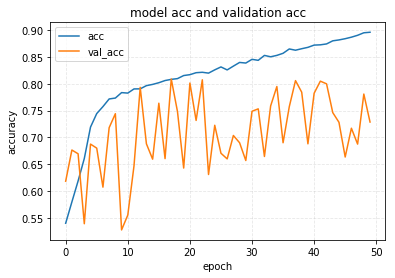

In [31]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model acc and validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()

# Plot First Time 

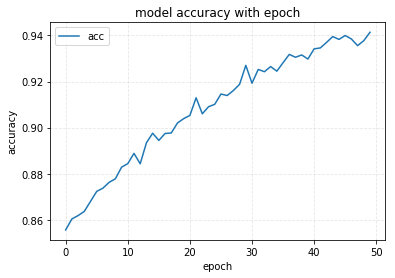

In [18]:
plt.plot(hist.history['acc'])
plt.title('model accuracy with epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc'], loc='best')
plt.show()

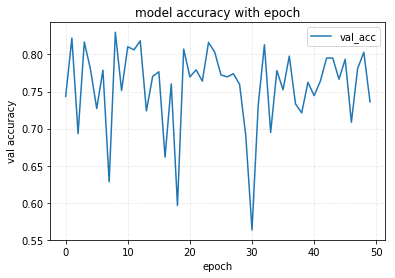

In [20]:
plt.plot(hist.history['val_acc'])
plt.title('model accuracy with epoch')
plt.ylabel('val accuracy')
plt.xlabel('epoch')
plt.legend(['val_acc'], loc='best')
plt.show()

# Just tried with an additional layer

In [25]:
def network_1(input_shape, learning_rate=0.0005, reg=0.0032, dropout=0.7436, seed=None):
    """ 
    Args:
    input_shape -- shape of the input spectra
    regularization_strength -- regularization factor
    dropout -- dropout rate
    seed -- seed of initializer
    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='Input_Spec')

    with K.name_scope('Conv_1'):
        X = Conv1D(filters=8, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X_input)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(pool_size= 2)(X)

    with K.name_scope('Conv_2'):
        X = Conv1D(filters=16, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
    with K.name_scope('Conv_3'):
        X = Conv1D(filters=32, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)
        
    with K.name_scope('Conv_4'):
        X = Conv1D(filters=64, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    with K.name_scope('Conv_5'):
        X = Conv1D(filters=128, kernel_size=5, strides=1, padding='same',
                   kernel_regularizer=regularizers.l2(reg),
                   bias_initializer='zeros',
                   kernel_initializer=glorot_normal(seed))(X)
        X = BatchNormalization(axis=2)(X)
        X = Activation('relu')(X)
        X = MaxPooling1D(2)(X)

    # FLATTEN -> FULLYCONNECTED
    with K.name_scope('Dense_Layer'):
        X = Flatten()(X)
        X = Dense(256, kernel_regularizer=regularizers.l2(reg),
                  activation='relu')(X)
        X = Dropout(rate=dropout, seed=seed)(X)
    
    with K.name_scope('Output_Layer'):
        X = Dense(1, kernel_regularizer=regularizers.l2(reg),
              activation='sigmoid',name='Output_Classes')(X)

    model = Model(inputs=X_input, outputs=X, name='SNnet')
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model3 = network_1((400,1))


In [ ]:
l = len(x_train)
hist1 = model3.fit(x_train[permute][:l],y_train[permute][:l],batch_size=64,epochs=30,
                  validation_split=0.1,shuffle=True)

Train on 17939 samples, validate on 1994 samples
Epoch 1/30
17939/17939 [==============================] - 35s 2ms/step - loss: 0.8642 - acc: 0.6170 - val_loss: 0.8480 - val_acc: 0.5948
Epoch 2/30
17939/17939 [==============================] - 35s 2ms/step - loss: 0.7289 - acc: 0.6999 - val_loss: 0.6751 - val_acc: 0.7342
Epoch 3/30
17939/17939 [==============================] - 35s 2ms/step - loss: 0.6379 - acc: 0.7509 - val_loss: 0.7142 - val_acc: 0.6505
Epoch 4/30
17939/17939 [==============================] - 35s 2ms/step - loss: 0.5884 - acc: 0.7762 - val_loss: 0.6862 - val_acc: 0.6911
Epoch 5/30
17939/17939 [==============================] - 35s 2ms/step - loss: 0.5563 - acc: 0.7863 - val_loss: 0.6794 - val_acc: 0.6780
Epoch 6/30
17939/17939 [==============================] - 34s 2ms/step - loss: 0.5369 - acc: 0.7962 - val_loss: 0.5393 - val_acc: 0.7894
Epoch 7/30
17939/17939 [==============================] - 34s 2ms/step - loss: 0.5170 - acc: 0.8059 - val_loss: 0.5739 - val_acc:

In [ ]:
plt.plot(hist1.history['acc'])
plt.plot(hist1.history['val_acc'])
plt.title('model acc and validation acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['acc', 'val_acc'], loc='best')
plt.show()